# Check the KdV input data

Mainly checking to see that there are no surprises in each dataset

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import h5py 
import numpy as np

In [2]:
%matplotlib inline

In [3]:
def load_beta_h5(betafile):
    # Get the time from the beta file
    with h5py.File(betafile,'r') as f:
        t_beta=f['data/time'][:].astype('<M8[ns]')
        beta_samples = f['beta_samples'][:]
        z_std = np.array(f['data/z_std'])
        rho_std = np.array(f['data/rho_std'])
        rho_mu = np.array(f['data/rho_mu'])

    nparams, nt, nsamples = beta_samples.shape
    return xr.DataArray(beta_samples, dims=('params','time','draw'), 
                 coords={'time':t_beta,'params':range(nparams), 'draw':range(nsamples)})

In [4]:
!ls -lah ../inputs/a0_samples_harmonic*.nc

-rwxrwxrwx 1 root root 79M May 10 15:24 ../inputs/a0_samples_harmonicfit_M2S2N2K1O1_na0_dt60min_12month.nc
-rwxrwxrwx 1 root root 83M May 10 16:06 ../inputs/a0_samples_harmonicfit_M2S2N2K1O1_na3_dt60min_12month.nc


In [5]:

###
# a0 files

# Older a0 file
aofile_ar = '../inputs/a0_samples_harmonicfit_M2S2N2K1O1_na0_AR5_12month.nc'

# Harmonics + stochastic component
a0file_ar = '../inputs/a0_samples_harmonicfit_M2S2N2K1O1_na0_AR4_dt20min_12month.nc'

# Seasonal harmonics model
a0file_ar = '../inputs/a0_samples_harmonicfit_M2S2N2K1O1_na3_dt60min_12month.nc'

# Deterministic harmonics only
# a0file = '../inputs/a0_samples_harmonicfit_M2S2N2K1O1P1_na0_dt20min_12month.nc'
a0file = '../inputs/a0_samples_harmonicfit_M2S2N2K1O1_na0_dt60min_12month.nc'

###
# beta (rho) files
outdir = '../inputs'
betafile = '%s/ShellCrux_Filtered_Density_Harmonic_MCMC_20162017_v5.h5'%outdir
betafile_mu = '%s/ShellCrux_Filtered_Density_Harmonic_MCMC_20162017_prediction_v5.h5'%outdir


In [6]:
a0_obs_ds = xr.open_dataset(a0file, group='observed_data')
a0_obs_ds

<xarray.Dataset>
Dimensions:      (X_obs_dim_0: 8952, time: 8952)
Coordinates:
  * X_obs_dim_0  (X_obs_dim_0) int64 0 1 2 3 4 5 ... 8947 8948 8949 8950 8951
  * time         (time) datetime64[ns] 2016-04-29T23:15:00 ... 2017-05-08T01:...
Data variables:
    X_obs        (time) float64 ...
Attributes:
    created_at:                 2021-05-10T07:24:54.932569
    arviz_version:              0.11.2
    inference_library:          pymc3
    inference_library_version:  3.11.2

In [7]:
# Load a0 and plot

a0_ds = xr.open_dataset(a0file, group='predictions')
a0_ar_ds = xr.open_dataset(a0file_ar, group='predictions')

In [19]:
beta_ds = load_beta_h5(betafile)
beta_mu_ds = load_beta_h5(betafile_mu)


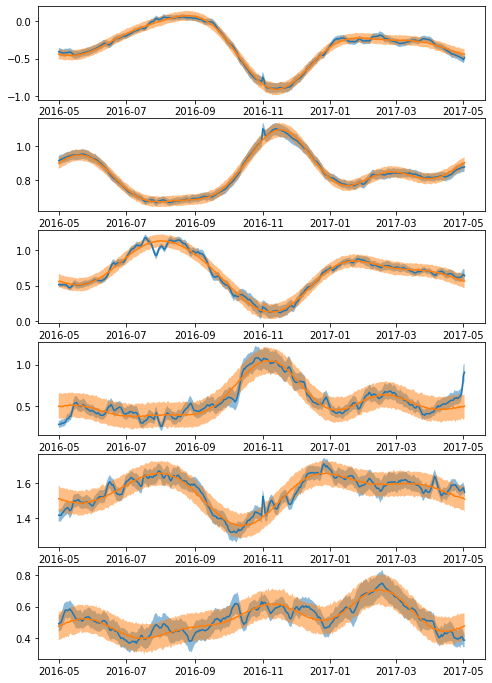

In [20]:
def plot_param(beta,ii):
    beta_low = np.percentile(beta[ii,...], 5, axis=-1)
    beta_high = np.percentile(beta[ii,...], 95, axis=-1)
    plt.plot(beta_ds.time, beta[ii,...].mean(axis=-1))
    plt.fill_between(beta_ds.time, beta_low, beta_high, alpha=0.5)

plt.figure(figsize=(8,12))
for ii in range(6):
    plt.subplot(6,1,ii+1)
    plot_param(beta_ds, ii)
    plot_param(beta_mu_ds, ii)


In [21]:
a0_ds

<xarray.Dataset>
Dimensions:  (chain: 1, draw: 500, time: 8785)
Coordinates:
  * chain    (chain) int64 1
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * time     (time) datetime64[ns] 2016-05-01 2016-05-01T01:00:00 ... 2017-05-02
Data variables:
    a0       (chain, draw, time) float64 ...
Attributes:
    created_at:                 2021-03-30T08:16:19.373131
    arviz_version:              0.11.2
    inference_library:          pymc3
    inference_library_version:  3.11.2

In [8]:
def get_credint(a0):
    a_low = np.percentile(a0['a0'][0,:,:],5, axis=0)
    a_high = np.percentile(a0['a0'][0,:,:],95, axis=0)
    return a_low, a_high

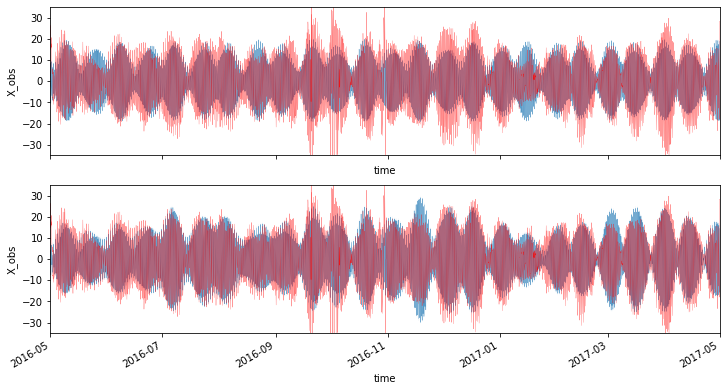

In [9]:
t1,t2 = np.datetime64('2016-05-01'),np.datetime64('2017-05-01')
# t1,t2 = np.datetime64('2016-05-01'),np.datetime64('2016-07-01')

plt.figure(figsize=(12,6))
ax=plt.subplot(211)
plt.plot(a0_ds.time, a0_ds['a0'][0,:,:].mean(axis=0), lw=0.3)
a_low, a_high = get_credint(a0_ds)
plt.fill_between(a0_ds.time, a_low, a_high, alpha=0.5)
plt.xlim(t1,t2)
plt.ylim(-35,35)
a0_obs_ds['X_obs'].plot(color='r',lw=0.2)
ax.set_xticklabels([])

ax2=plt.subplot(212)
plt.plot(a0_ar_ds.time, a0_ar_ds['a0'][0,:,:].mean(axis=0), lw=0.3)
a_low, a_high = get_credint(a0_ar_ds)
plt.fill_between(a0_ar_ds.time, a_low, a_high, alpha=0.5)
plt.xlim(t1,t2)
plt.ylim(-35,35)
a0_obs_ds['X_obs'].plot(color='r',lw=0.2)


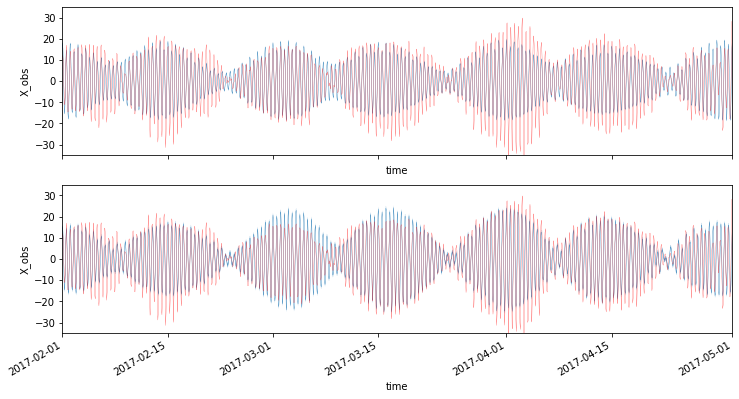

In [10]:
# t1,t2 = np.datetime64('2016-05-01'),np.datetime64('2017-05-01')
t1,t2 = np.datetime64('2017-02-01'),np.datetime64('2017-05-01')

plt.figure(figsize=(12,6))
ax=plt.subplot(211)
plt.plot(a0_ds.time, a0_ds['a0'][0,:,:].mean(axis=0), lw=0.3)
a_low, a_high = get_credint(a0_ds)
plt.fill_between(a0_ds.time, a_low, a_high, alpha=0.5)
plt.xlim(t1,t2)
plt.ylim(-35,35)
a0_obs_ds['X_obs'].plot(color='r',lw=0.2)
ax.set_xticklabels([])

ax2=plt.subplot(212)
plt.plot(a0_ar_ds.time, a0_ar_ds['a0'][0,:,:].mean(axis=0), lw=0.3)
a_low, a_high = get_credint(a0_ar_ds)
plt.fill_between(a0_ar_ds.time, a_low, a_high, alpha=0.5)
plt.xlim(t1,t2)
plt.ylim(-35,35)
a0_obs_ds['X_obs'].plot(color='r',lw=0.2)
